In [ ]:
import pandas as pd
import gc
import numpy as np
import math
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
import re
import shap

from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

#Stacking
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Functions

In [ ]:
def make_corr(variables, data, figsize=(10, 15)):
    if isinstance(variables, pd.DataFrame):
        variables = variables['Column Name'].tolist()

    cols = variables

    corr_matrix = data[cols].corr()

    # Create a heatmap with the specified figsize
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, center=0.0)

    plt.title('Correlation Heatmap for Columns Starting with C')
    plt.show()
    
# We will focus on each column in detail
# Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
def column_details(regex, df):
  
    global columns
    columns=[col for col in df.columns if re.search(regex, col)]

    from colorama import Fore, Back, Style

    print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
    for i in df[columns]:
        color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
        print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')

def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#Plot Functions

def plot_col(col, df, figsize=(20, 6)):
    """
    Function to create a pair of subplots containing two graphs based on a specified column.

    Left Graph (First Subplot):
    - Draws a bar graph representing the percentage of Fraud cases with respect to the specified column.
    - Uses two colors (0 and 1) to represent Fraud and Non-Fraud cases.
    - Adds a second line graph on the same column, representing the percentage of Fraud cases.

    Right Graph (Second Subplot):
    - Draws a bar graph representing the number of unique values in the dataset based on the specified column.

    The purpose of this function is to visualize the relationship between Fraud status, unique values, and missing values in a specific column.

    :param col: Name of the column to be visualized.
    :param df: Dataset.
    :param figsize: Size of the created figure.
    """

    # Create a copy of the DataFrame to ensure the original DataFrame is not modified
    df_copy = df.copy()

    # Handle NaN values by filling them with 'Missing' in the copied DataFrame
    df_copy[col] = df_copy[col].fillna('Missing')

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left Graph: Bar graph and line graph for Fraud percentages
    plt.subplot(121)
    tmp = pd.crosstab(df_copy[col], df_copy['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df_copy, hue='isFraud', order=np.sort(df_copy[col].unique()))
    ax[0].tick_params(axis='x', rotation=90)

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=np.sort(df_copy[col].unique()))

    ax[0].grid()

    # Right Graph: Bar graph for the number of unique values in the column
    plt.subplot(122)
    ax[1] = sns.countplot(x=df_copy[col], order=np.sort(df_copy[col].unique()))

    plt.show()


#correlation functions
#for xgboost : For perfectly correlated variables(100%), there is no impact on model performance — neither on train and nor on validation dataset. 
# Also, there is no change in variable importance and rank order 
# In case of partially correlated features, the output of XGBoost is slightly impacted. 
# We see a marginal change in the performance of the model, suggesting the robustness of XGBoost when dealing with correlated variables.
# However, one may note that the partially correlated variables in the model are affecting the variable importance.
# reference link: https://vishesh-gupta.medium.com/correlation-in-xgboost-8afa649bd066 

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Check distinct values for each correlated pair
                distinct_values_col = len(x[col[0]].unique())
                distinct_values_row = len(x[row[0]].unique())

                # Keep the one with more distinct values
                if distinct_values_col > distinct_values_row:
                    drop_cols.append(row.values[0])
                else:
                    drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#outlier functions
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

def identify_collinear_categorical_features(df, columns, threshold):
    """
    Objective:
        Identify collinear categorical features in a dataframe with Cramér's V greater than the threshold.

    Inputs:
        df: dataframe
        columns: list of column names to check for collinearity
        threshold: features with Cramér's V greater than this value are considered collinear

    Output:
        list of columns to drop
    """
    # Create an empty DataFrame to store the results
    cramers_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    # Fill in the Cramér's V values for each pair of columns
    for col1 in columns:
        for col2 in columns:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Identify columns to drop based on Cramér's V threshold
    drop_cols = set()
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j and cramers_v_matrix.loc[col1, col2] > threshold:
                drop_cols.add(col2)

    return list(drop_cols)

def remove_collinear_categorical_features(df, drop_cols):
    """
    Objective:
        Remove collinear categorical features from a dataframe.

    Inputs:
        df: dataframe
        drop_cols: list of columns to drop

    Output:
        dataframe that contains only the non-highly-collinear features
    """
    # Drop the identified columns
    df = df.drop(columns=drop_cols)

    return df

#Encoders
# Frequency Encoding

def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq_encoded'] = train[col].map(fq_encode)
            test[col+'_freq_encoded']  = test[col].map(fq_encode)
    return train, test

#Modeling
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

#### Pickling Final Train and Test

In [ ]:
# Read the 'train_3.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('./train_12.pkl')

# Read the 'test_3.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('./test_12.pkl')

#### Removing Date columns

In [ ]:
# Date columns are not indicators
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('DT', axis=1, inplace=True)

test.drop('TransactionDT', axis=1, inplace=True)
test.drop('DT', axis=1, inplace=True)

#### Defining X sets and Y

In [ ]:
# Target variable for training set (y_train)
y_train = train['isFraud']

# Independent variables for training set (X_train)
X_train = train.drop(['isFraud'], axis=1)

# Target variable for test set (y_test)
y_test = test['isFraud']

# Independent variables for test set (X_test)
X_test = test.drop(['isFraud'], axis=1)

#### PCA

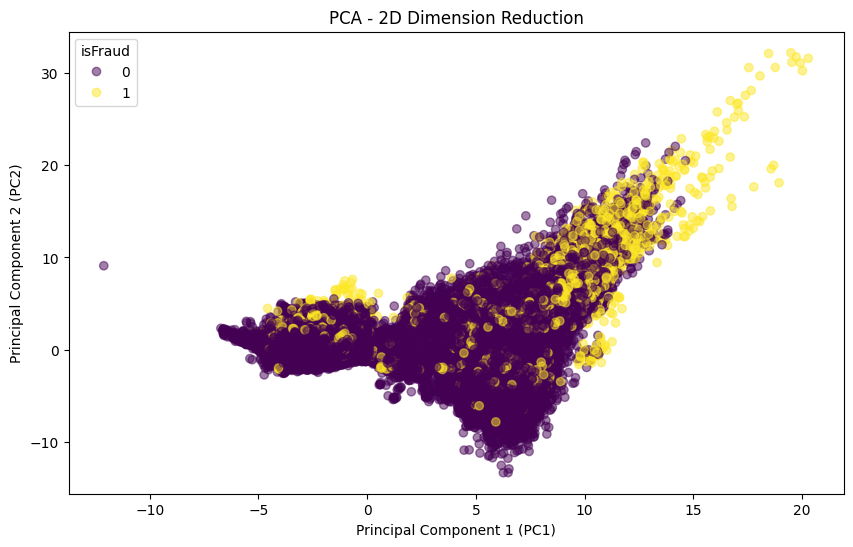

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_pca = X_train.replace([np.inf, -np.inf], np.nan)
X_train_pca = X_train.fillna(X_train.mean())

# Standardization (z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create DataFrame
pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
pca_df['isFraud'] = y_train.values

# 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['isFraud'], cmap='viridis', alpha=0.5)
plt.title('PCA - 2D Dimension Reduction')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(*scatter.legend_elements(), title='isFraud')
plt.show()


#### Default Model

In [ ]:
# Get the count of negative and positive examples
count_negative = (y_train == 0).sum()
count_positive = (y_train == 1).sum()

# Calculate the value of scale_pos_weight
scale_pos_weight = math.sqrt(count_negative / count_positive)

In [ ]:
#XGBoost with default parameters
xgb = XGBClassifier(objective='binary:logistic', random_state=1003, 
                    eval_metric='auc', 
                    scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

#prediction
y_pred_xgb = xgb.predict(X_test)

#classification report
print(classification_report(y_test, y_pred_xgb))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.52      0.43      0.47      5100

    accuracy                           0.97    147635
   macro avg       0.75      0.71      0.73    147635
weighted avg       0.96      0.97      0.96    147635

[[0.98591925 0.01408075]
 [0.57470588 0.42529412]]


In [ ]:
# Probas for train
y_train_xgb_proba = xgb.predict_proba(X_train)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9673969656834689
Test AUC: 0.8855572102345692


In [ ]:
# Feature Importance
cols = list( X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

In [ ]:
len(X_train.columns)

217

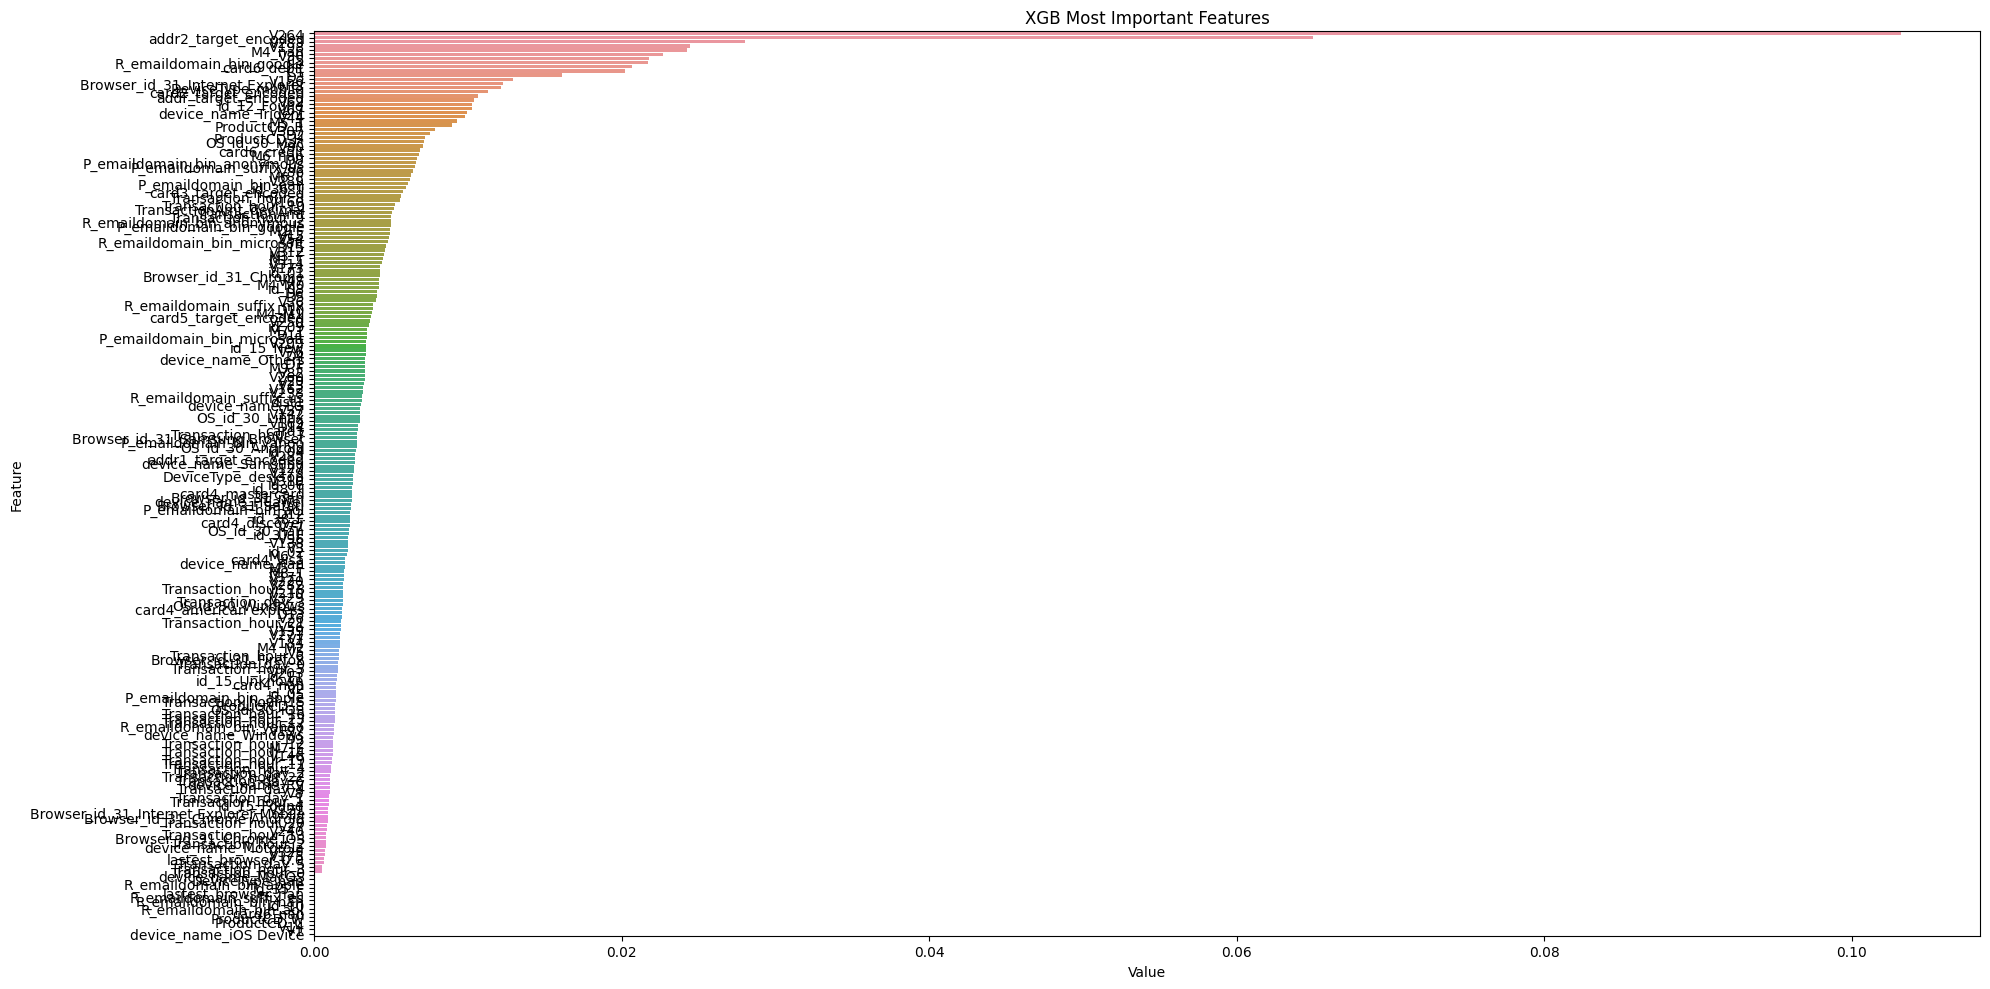

In [ ]:
# Plotting feature importance with all variables (217 vars)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

#### Second Model with first 100 important features and default parameters

In [ ]:
# Select the top 50 important features from X_train
selected_features = feature_imp.head(100)['Feature'].tolist()

# Creating new x dataframes
X_train_2 = X_train[selected_features]
X_test_2 = X_test[selected_features]

In [ ]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_2 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_2.fit(X_train_2, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_2 = xgb_2.predict(X_test_2)

#classification report
print(classification_report(y_test, y_pred_xgb_2))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb_2, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.52      0.45      0.48      5100

    accuracy                           0.97    147635
   macro avg       0.75      0.72      0.73    147635
weighted avg       0.96      0.97      0.97    147635

[[0.98548427 0.01451573]
 [0.55490196 0.44509804]]


In [ ]:
# Probas for train
y_train_xgb_proba_2 = xgb_2.predict_proba(X_train_2)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_2)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_2 = xgb_2.predict_proba(X_test_2)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_2)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9656954324710703
Test AUC: 0.8900466063718784


In [ ]:
# Feature Importance
cols = list( X_train_2.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb_2.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

#### Third Model with first 50 important features and default parameters

In [ ]:
# Select the top 50 important features from X_train
selected_features = feature_imp.head(50)['Feature'].tolist()

# Creating new x dataframes
X_train_3 = X_train[selected_features]
X_test_3 = X_test[selected_features]

In [ ]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_3 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_3.fit(X_train_3, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_3 = xgb_3.predict(X_test_3)

#classification report
print(classification_report(y_test, y_pred_xgb_3))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb_3, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142535
           1       0.49      0.44      0.47      5100

    accuracy                           0.97    147635
   macro avg       0.74      0.71      0.72    147635
weighted avg       0.96      0.97      0.96    147635

[[0.98370926 0.01629074]
 [0.55764706 0.44235294]]


In [ ]:
# Probas for train
y_train_xgb_proba_3 = xgb_3.predict_proba(X_train_3)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_3)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_3 = xgb_3.predict_proba(X_test_3)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_3)
print(f'Test AUC: {test_auc}')


Train AUC: 0.959119123939
Test AUC: 0.8806875325427467


In [ ]:
# Feature Importance
cols = list( X_train_3.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb_3.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

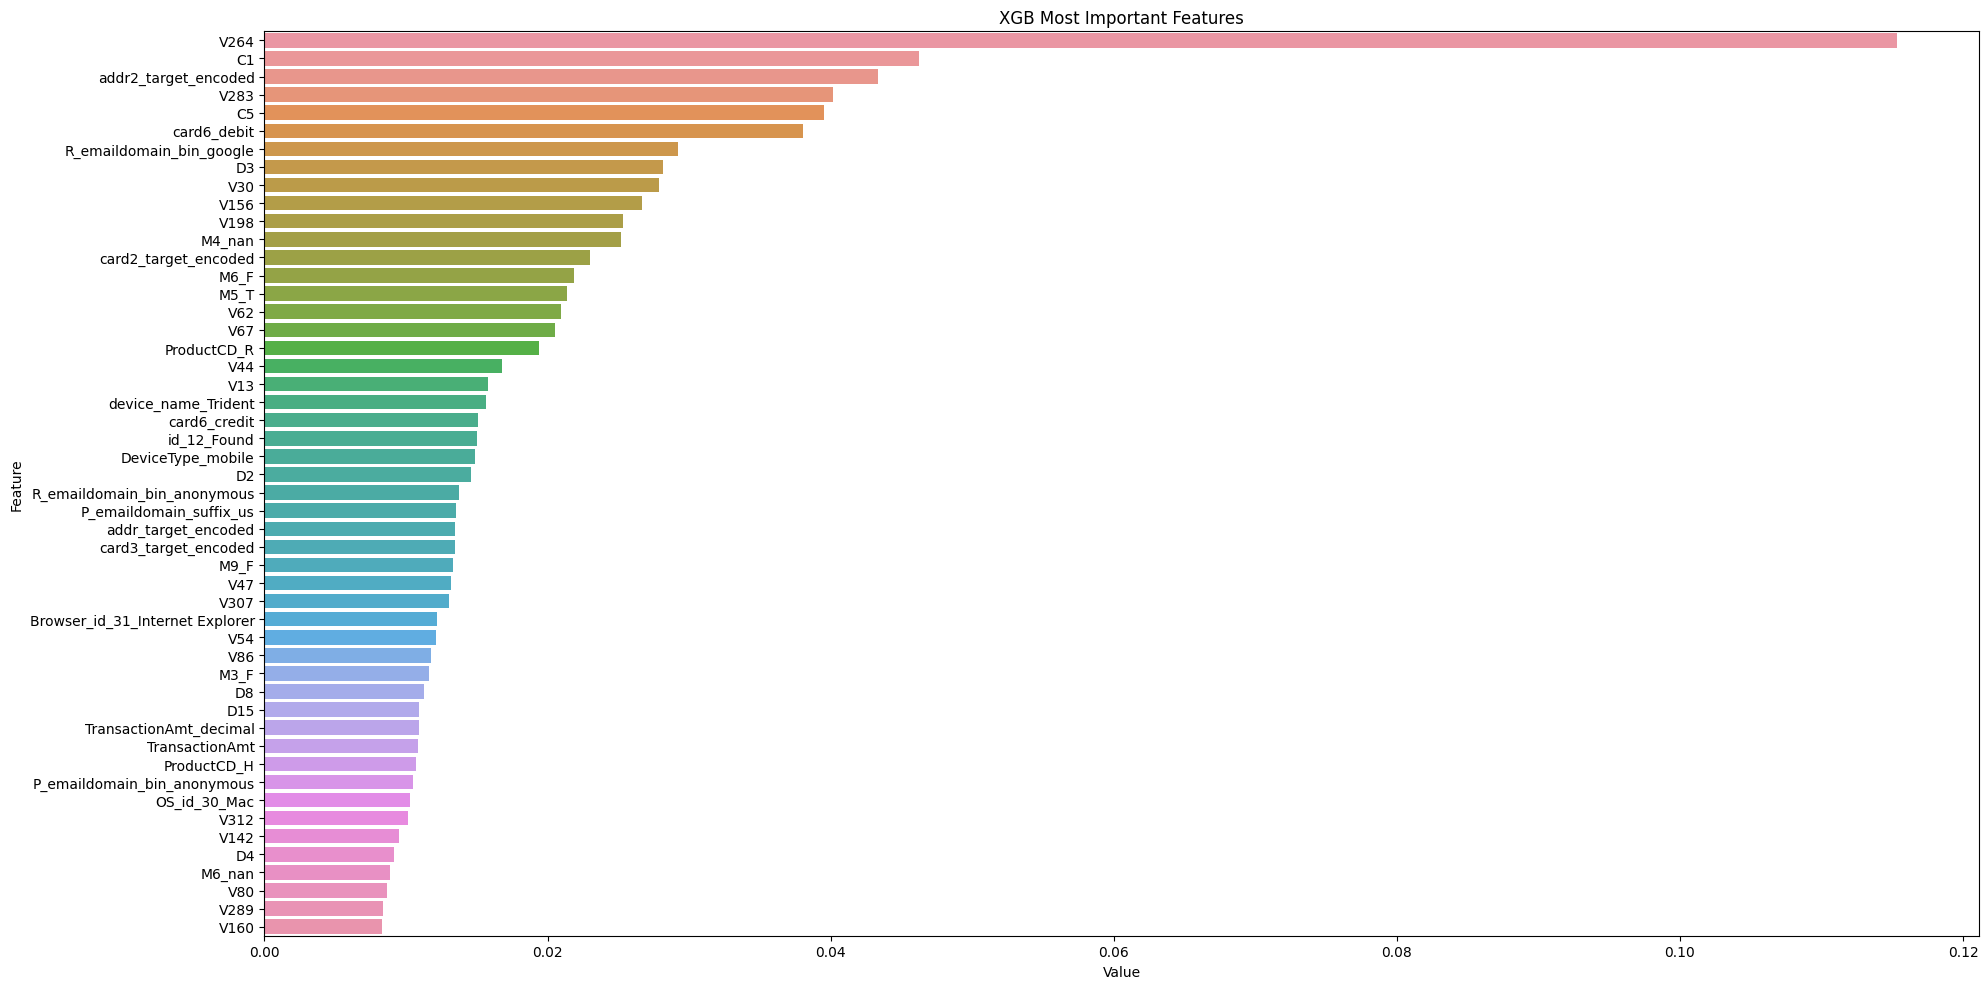

In [ ]:
# Plotting feature importance with selected 50 params
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

#### Fourth Model with first 45 important features and default parameters

In [ ]:
# Select the top 50 important features from X_train
features_to_remove = ["card6_credit", "M6_nan", "ProductCD_H", "R_emaildomain_bin_anonymous"]
filtered_features = [feature for feature in selected_features if feature not in features_to_remove]

# Creating new x dataframes
X_train_4 = X_train[filtered_features]
X_test_4 = X_test[filtered_features]

In [ ]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_4 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_4.fit(X_train_4, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_4 = xgb_4.predict(X_test_4)

#classification report
print(classification_report(y_test, y_pred_xgb_4))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb_4, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142535
           1       0.49      0.44      0.46      5100

    accuracy                           0.96    147635
   macro avg       0.73      0.71      0.72    147635
weighted avg       0.96      0.96      0.96    147635

[[0.98333041 0.01666959]
 [0.55705882 0.44294118]]


In [ ]:
# Probas for train
y_train_xgb_proba_4 = xgb_4.predict_proba(X_train_4)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_4)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_4 = xgb_4.predict_proba(X_test_4)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_4)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9595233271781525
Test AUC: 0.882539419626552


In [ ]:
# Feature Importance
cols = list( X_train_4.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb_4.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

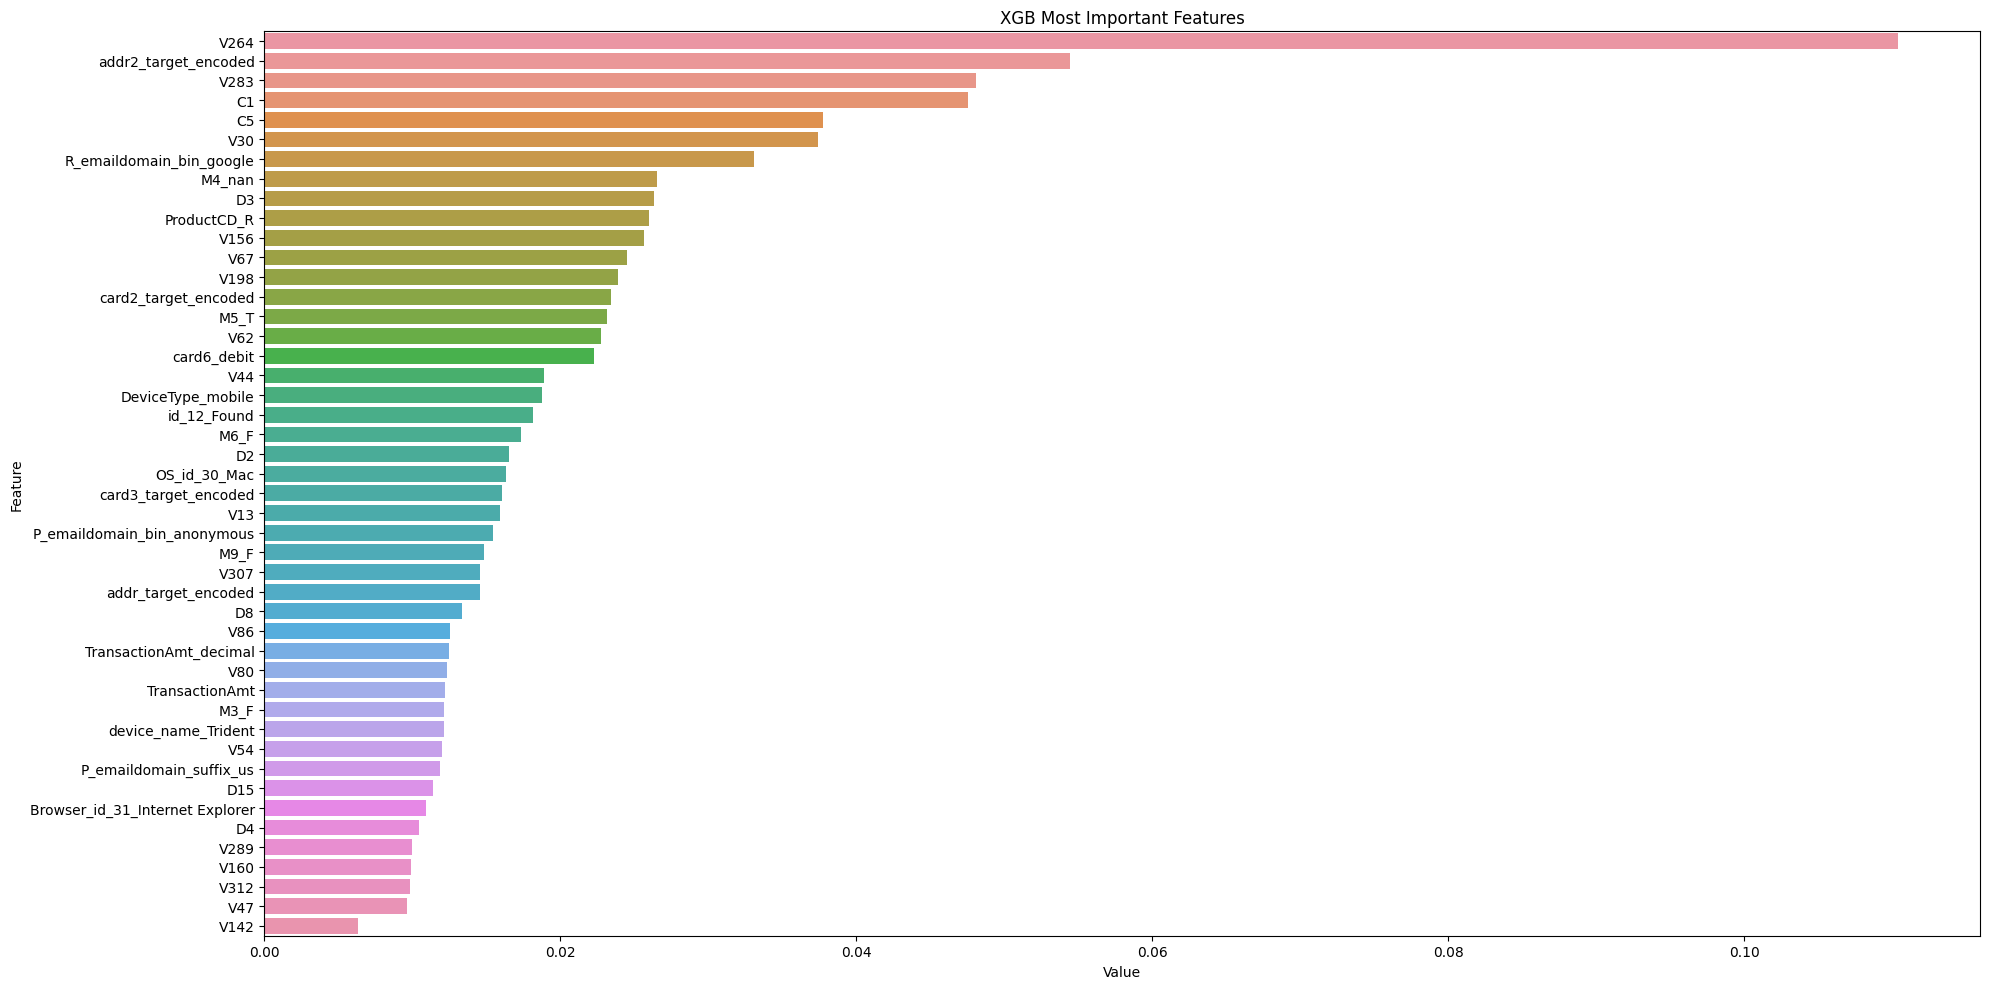

In [ ]:
# Plotting feature importance with selected 46 params
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

#### PCA-2

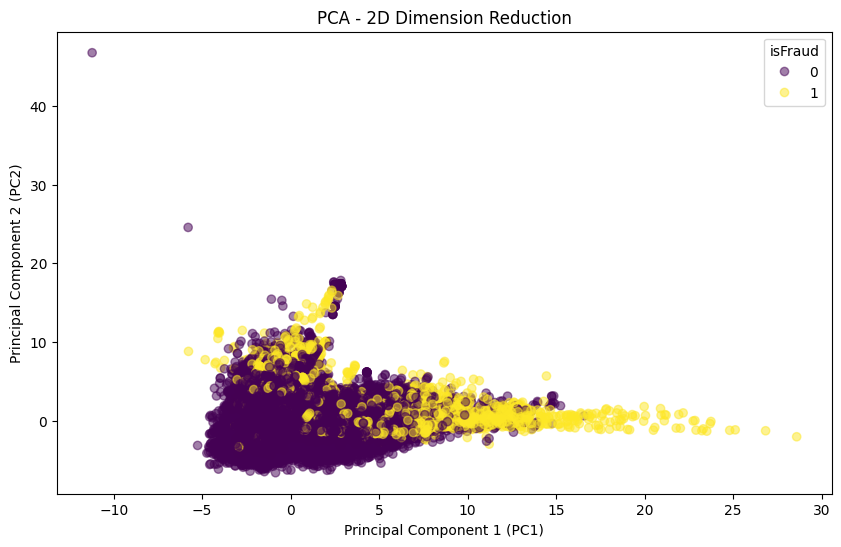

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_4_pca = X_train_4.replace([np.inf, -np.inf], np.nan)
X_train_4_pca = X_train_4.fillna(X_train_4.mean())

# Standardization (z-score normalization)
scaler = StandardScaler()
X_train_4_scaled = scaler.fit_transform(X_train_4_pca)

# Apply PCA
pca = PCA(n_components=2)
X_train_4_pca = pca.fit_transform(X_train_4_scaled)

# Create DataFrame
pca_df = pd.DataFrame(data=X_train_4_pca, columns=['PC1', 'PC2'])
pca_df['isFraud'] = y_train.values

# 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['isFraud'], cmap='viridis', alpha=0.5)
plt.title('PCA - 2D Dimension Reduction')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(*scatter.legend_elements(), title='isFraud')
plt.show()


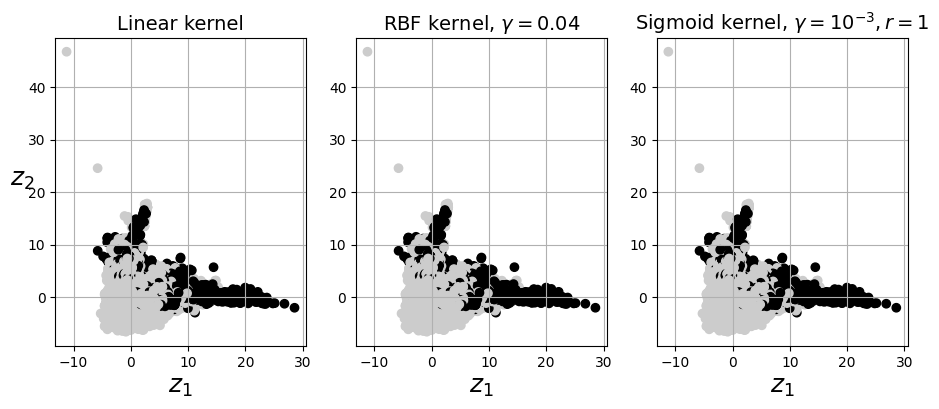

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(X_train_4_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

#### Cross Validation

In [ ]:
# Set the number of folds
num_folds = 5

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation with AUC as the scoring metric
cross_val_results_auc = cross_val_score(xgb_4, X_train_4, y_train, cv=kf, scoring='roc_auc')

# Print the cross-validation results
print(f'Cross-Validation Results (AUC): {cross_val_results_auc}')
print(f'Mean AUC: {cross_val_results_auc.mean()}')
print(f'Standard Deviation: {cross_val_results_auc.std()}')

Cross-Validation Results (AUC): [0.93325591 0.93632224 0.93575867 0.93448194 0.93249466]
Mean AUC: 0.9344626837234958
Standard Deviation: 0.0014468806359034438


In [ ]:
# Set the number of folds
num_folds = 10

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation with AUC as the scoring metric
cross_val_results_auc = cross_val_score(xgb_4, X_train_4, y_train, cv=kf, scoring='roc_auc')

# Print the cross-validation results
print(f'Cross-Validation Results (AUC): {cross_val_results_auc}')
print(f'Mean AUC: {cross_val_results_auc.mean()}')
print(f'Standard Deviation: {cross_val_results_auc.std()}')

Cross-Validation Results (AUC): [0.93444471 0.93623077 0.93641653 0.93566042 0.93959624 0.93525938
 0.93472144 0.93593435 0.94087672 0.93373486]
Mean AUC: 0.9362875421940571
Standard Deviation: 0.0021440140705784633


#### Final Model with Fine Tuning

In [ ]:
# Select the top 46 important features from X_train

# Creating new x dataframes
X_train_5 = X_train[filtered_features]
X_test_5 = X_test[filtered_features]

parameter tuning is a must to get the best parameter values. 
XGBoost is also known as a ‘regularized boosting‘ technique.
XGBoost implements parallel processing and is blazingly faster as compared to Standard GBM.
XGBoost allows users to define custom optimization objectives and evaluation criteria. This adds a whole new dimension to the model and there is no limit to what we can do.

* Built-in Cross-Validation: XGBoost allows the user to run a cross-validation at each iteration of the boosting process and thus, it is easy to get the exact optimum number of boosting iterations in a single run.

The overall parameters have been divided into 3 categories by XGBoost authors:

* General Parameters: Guide the overall functioning
* Booster Parameters: Guide the individual booster (tree/regression) at each step
* Learning Task Parameters: Guide the optimization performed

In [ ]:
merged_train = pd.concat([X_train_5, y_train], axis=1)
merged_test = pd.concat([X_test_5, y_test], axis=1)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb

In [ ]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['isFraud'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds)

        alg.set_params(n_estimators=cvresult.shape[0])
        
        # Display best iteration information
        print("Best iteration: %d" % (cvresult.shape[0]))
        print("cv-mean: %f" % (cvresult['test-auc-mean'].iloc[-1]))
        print("cv-std: %f" % (cvresult['test-auc-std'].iloc[-1]))
        
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['isFraud'], eval_metric='auc')
    
    # Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
    
    # Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain['isFraud'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain['isFraud'], dtrain_predprob))
    
    # Predict on testing data
    dtest_predprob = alg.predict_proba(dtest[predictors])[:, 1]
    print('AUC Score (Test): %f' % roc_auc_score(dtest['isFraud'], dtest_predprob))
    
    # Plot feature importances
    feat_imp = pd.Series(alg.feature_importances_, index=predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

early_stopping_rounds=50, meaning that if the 'auc' metric doesn't improve for 50 consecutive rounds, the training process will stop, and the best model up to that point will be used.

Step 1: Fix the learning rate and number of estimators for tuning tree-based parameters.
* Let’s take the default learning rate of 0.3 here and check the optimum number of trees using the cv function of xgboost.

Best iteration: 1000
cv-mean: 0.946539
cv-std: 0.000956

Model Report
Accuracy : 0.983
AUC Score (Train): 0.978706
AUC Score (Test): 0.887444


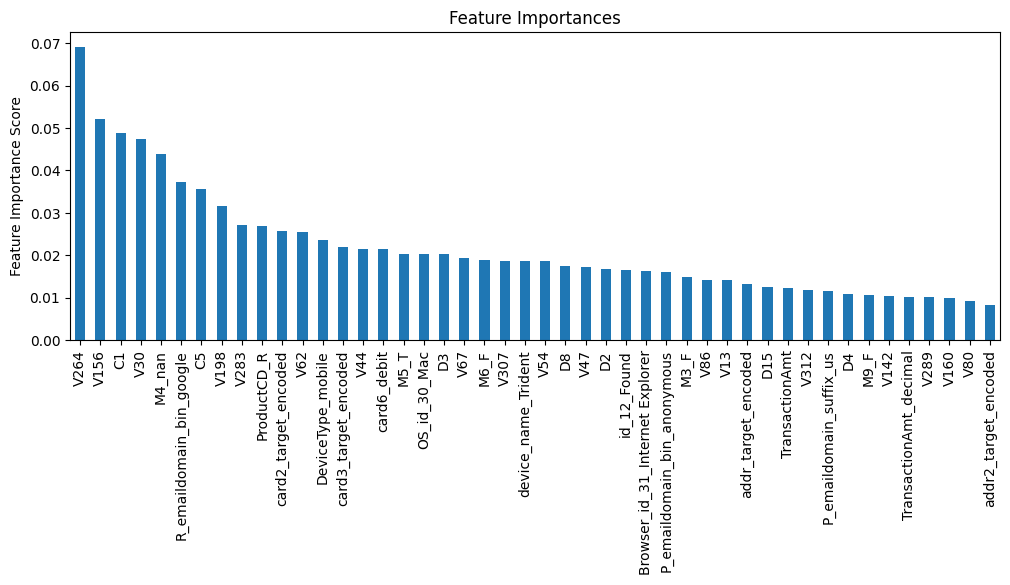

In [ ]:
predictors = [x for x in merged_train.columns if x not in ['isFraud']]
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5, # This should be between 3-10. I’ve started with 5, but you can choose a different number as well. 4-6 can be good starting points
    min_child_weight=1, # A smaller value is chosen because it is a highly imbalanced class problem, and leaf nodes can have smaller size groups.
    gamma=0, # A smaller value like 0.1-0.2 can also be chosen for starting. This will, anyways, be tuned later.
    subsample=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    colsample_bytree=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    objective='binary:logistic',
    n_jobs=4,
    scale_pos_weight=scale_pos_weight, #Because of high-class imbalance.
    base_score = 0.18,
    tree_method = 'gpu_hist',
    seed=1003)
modelfit(xgb1, merged_train, merged_test, predictors)


here we got 1000 as the optimal estimator for a 0.1 learning rate.

Step 2: Tune max_depth and min_child_weight.
* We tune these first as they will have the highest impact on the model outcome. To start with, let’s set wider ranges, and then we will perform another iteration for smaller ranges.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic',scale_pos_weight=scale_pos_weight,
 seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train['isFraud'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([18.39452863, 18.48022532, 18.88941441, 22.77359667, 22.31871624,
         23.61614375, 31.64558392, 31.55470705, 31.06889868, 50.70743318,
         46.92255778, 39.89711881]),
  'std_fit_time': array([0.0629641 , 0.08143148, 0.2930606 , 0.79204852, 0.57181498,
         0.84418323, 0.37888287, 0.53518471, 0.38412326, 1.02170509,
         0.48205775, 4.58460475]),
  'mean_score_time': array([0.22555017, 0.24222569, 0.26607904, 0.27212219, 0.28863444,
         0.29042439, 0.29318633, 0.30925751, 0.30906363, 0.35859628,
         0.33411956, 0.31250067]),
  'std_score_time': array([0.02277312, 0.02304979, 0.02102384, 0.02184776, 0.03066728,
         0.01103741, 0.01659285, 0.01153528, 0.03977756, 0.03690156,
         0.01763386, 0.06040801]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 3 for min_child_weight. Let’s go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight= scale_pos_weight, 
 seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train['isFraud'])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([20.5852829 , 20.34148107, 20.24359202, 22.40627933, 21.84802442,
         22.2216578 , 25.53680758, 25.57226343, 23.11781006]),
  'std_fit_time': array([0.0837347 , 0.1053441 , 0.11570649, 0.75076852, 1.21367827,
         0.96540141, 0.4545343 , 0.47381832, 3.48407226]),
  'mean_score_time': array([0.18764663, 0.23381748, 0.24518433, 0.2254756 , 0.25863457,
         0.26377659, 0.30740719, 0.28970399, 0.26517391]),
  'std_score_time': array([0.01854442, 0.02268929, 0.02011015, 0.02283213, 0.03650916,
         0.03291027, 0.02873979, 0.03204652, 0.05204744]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],


Here, we get the optimum values as 5 for max_depth and 3 for min_child_weight. 

In [ ]:
#but we haven’t tried values less than 4 for min_child_weight. (only tried 1 and 3, not 2) We can do that as follow:
param_test2b = {
  'min_child_weight':[2,4]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight= scale_pos_weight, seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(train[predictors],train['isFraud'])
gsearch2b.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([19.96011829, 19.52957406, 19.2292418 , 21.66889901, 21.4724463 ,
         22.17196841, 25.79796171, 25.90510392, 24.21790099]),
  'std_fit_time': array([0.28299731, 0.48560112, 1.28776568, 0.72296141, 1.10560458,
         1.08524863, 0.41697557, 0.45744332, 1.88069072]),
  'mean_score_time': array([0.22088184, 0.25360084, 0.22644444, 0.22594695, 0.26481261,
         0.27121215, 0.26993928, 0.26073341, 0.23963027]),
  'std_score_time': array([0.01797391, 0.00929268, 0.03367058, 0.014864  , 0.02596515,
         0.03983604, 0.01885377, 0.02089868, 0.03579434]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],


Step 3: Tune gamma. 
* Now let’s tune the gamma value using the parameters already tuned above. Gamma can take various values, but I’ll check for 5 values here. You can go into more precise values.

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight= scale_pos_weight, 
 seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(merged_train[predictors],merged_train['isFraud'])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([23.70949845, 23.45511789, 23.26088924, 22.80249934, 19.74591932]),
  'std_fit_time': array([0.14905118, 0.09027868, 0.23036309, 0.33994729, 5.41039937]),
  'mean_score_time': array([0.24728088, 0.24973125, 0.2268012 , 0.24013476, 0.23467007]),
  'std_score_time': array([0.03486429, 0.04778017, 0.03734604, 0.03263366, 0.04525096]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.89242276, 0.89222134, 0.8923954 , 0.89133297, 0.89159529]),
  'split1_test_score': array([0.91534895, 0.91564136, 0.91528095, 0.91542588, 0.9149519 ]),
  'split2_test_score': array([0.91604154, 0.91592427, 0.9157308 , 0.91960384, 0.91852966]),
  'split3_test_score': array([0.89441592, 0.89398497, 0.8922993 , 0.89235515, 0.891771

This shows that our original value of gamma, i.e., 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

Best iteration: 1000
cv-mean: 0.945782
cv-std: 0.001146

Model Report
Accuracy : 0.9825
AUC Score (Train): 0.977068
AUC Score (Test): 0.887978


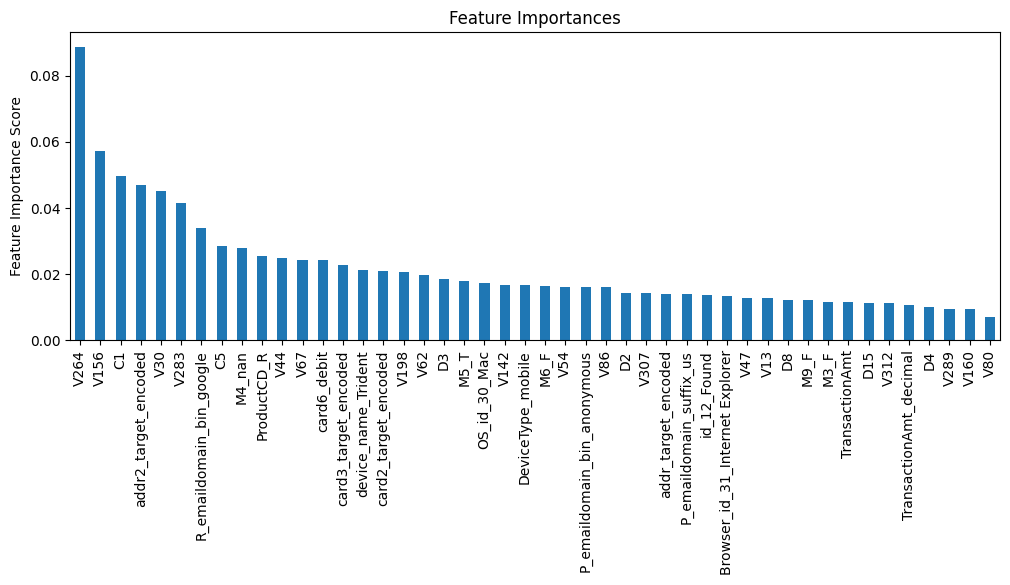

In [ ]:
xgb2 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5, # This should be between 3-10. I’ve started with 5, but you can choose a different number as well. 4-6 can be good starting points
    min_child_weight=4, # A smaller value is chosen because it is a highly imbalanced class problem, and leaf nodes can have smaller size groups.
    gamma=0.3, # A smaller value like 0.1-0.2 can also be chosen for starting. This will, anyways, be tuned later.
    subsample=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    colsample_bytree=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    objective='binary:logistic',
    n_jobs=4,
    scale_pos_weight=scale_pos_weight, #Because of high-class imbalance.
    tree_method = 'gpu_hist',
    seed=27)

modelfit(xgb2, merged_train, merged_test, predictors)

So the final parameters are:

* max_depth: 5
* min_child_weight: 4
* gamma: 0.3

Step 4: Tune subsample and colsample_bytree

The next step would be to try different subsample and colsample_bytree values. Let’s do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight= scale_pos_weight,
 seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(merged_train[predictors],merged_train['isFraud'])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([23.73037691, 23.09693871, 22.60792508, 21.98628039, 21.94218898,
         22.06560082, 22.06219802, 21.62909007, 21.95909667, 21.84171534,
         21.87840519, 21.81857076, 22.02513313, 21.84861746, 22.03822422,
         18.41224661]),
  'std_fit_time': array([0.30916155, 0.26064346, 0.37446701, 0.76750271, 1.29300179,
         0.69919389, 0.49868179, 0.59408955, 0.49243807, 0.44899773,
         0.48949493, 0.45295415, 0.66819472, 0.55728394, 0.43530492,
         3.27666843]),
  'mean_score_time': array([0.25481095, 0.23017826, 0.24191084, 0.26750913, 0.27153773,
         0.2767909 , 0.27228212, 0.26765437, 0.26324296, 0.2754848 ,
         0.26341925, 0.29059763, 0.27308574, 0.28777308, 0.33453069,
         0.26608582]),
  'std_score_time': array([0.01682718, 0.02706274, 0.03555667, 0.00927272, 0.02625491,
         0.03359802, 0.02744959, 0.02502315, 0.03535943, 0.01414259,
         0.01788288, 0.015065  , 0.02755881, 0.02751989, 0.03139826,
         0.049835

optimum values are:

subsample: 0.8
colsample_bytree: 0.8

Step 5: Tuning regularization parameters
* The next step is to apply regularization to reduce overfitting. However, many people don’t use this parameter much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune the ‘reg_alpha’ value here and different values of ‘reg_lambda’.

In [ ]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=1000, max_depth=5,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight= scale_pos_weight, 
 seed=27, tree_method ='gpu_hist'), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(merged_train[predictors],merged_train['isFraud'])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([24.10741191, 23.84495659, 23.7351871 , 23.47116961, 21.79443302]),
  'std_fit_time': array([0.19230379, 0.23616574, 0.46379326, 0.86016112, 5.55689902]),
  'mean_score_time': array([0.29752507, 0.2900156 , 0.29243193, 0.27801251, 0.2450706 ]),
  'std_score_time': array([0.05275247, 0.05364155, 0.03659887, 0.02164543, 0.05839836]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.89133297, 0.8908048 , 0.89178158, 0.89208283, 0.89107476]),
  'split1_test_score': array([0.91542588, 0.91552365, 0.91590497, 0.91527674, 0.91128041]),
  'split2_test_score': array([0.91960384, 0.91704705, 0.91692043, 0.91602051, 0.90915045]),
  'split3_test_score': array([0.89235516, 0.89184443, 0.8921

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

Best iteration: 1000
cv-mean: 0.945782
cv-std: 0.001146

Model Report
Accuracy : 0.9825
AUC Score (Train): 0.977068
AUC Score (Test): 0.887978


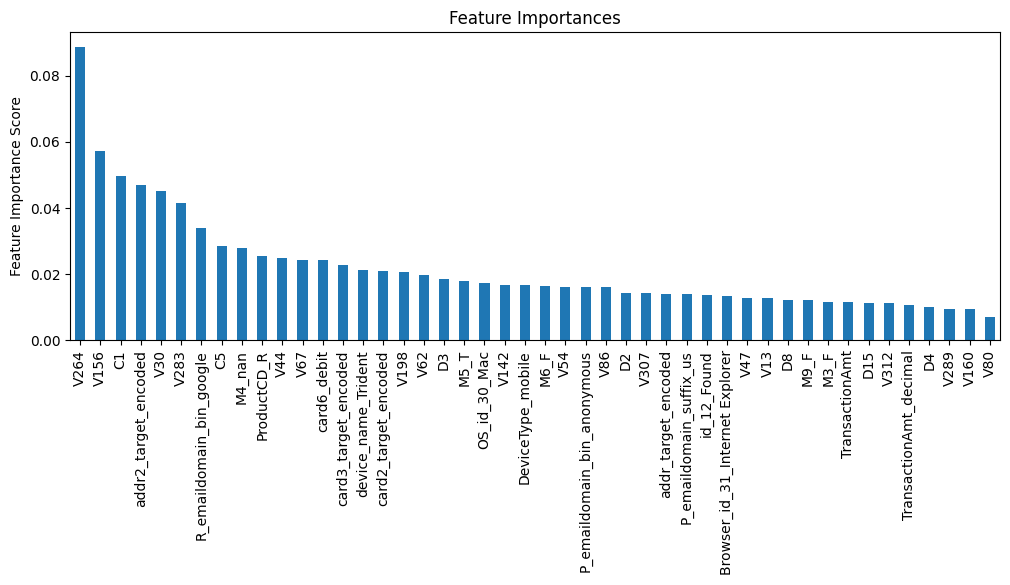

In [ ]:
xgb3 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5, # This should be between 3-10. I’ve started with 5, but you can choose a different number as well. 4-6 can be good starting points
    min_child_weight=4, # A smaller value is chosen because it is a highly imbalanced class problem, and leaf nodes can have smaller size groups.
    gamma=0.3, # A smaller value like 0.1-0.2 can also be chosen for starting. This will, anyways, be tuned later.
    subsample=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    colsample_bytree=0.8, # This is a commonly used start value. Typical values range between 0.5-0.9.
    objective='binary:logistic',
    n_jobs=4,
    reg_alpha = 0.000005,
    scale_pos_weight=scale_pos_weight, #Because of high-class imbalance.
    tree_method = 'gpu_hist',
    seed=27)

modelfit(xgb3, merged_train, merged_test, predictors)

Step 6: Reducing the learning rate and final calibration on parameters
* Lastly, we should lower the learning rate and add more trees. Let’s use the cv function of XGBoost to do the job again.

Best iteration: 1000
cv-mean: 0.909889
cv-std: 0.000932

Model Report
Accuracy : 0.9703
AUC Score (Train): 0.918178
AUC Score (Test): 0.877028


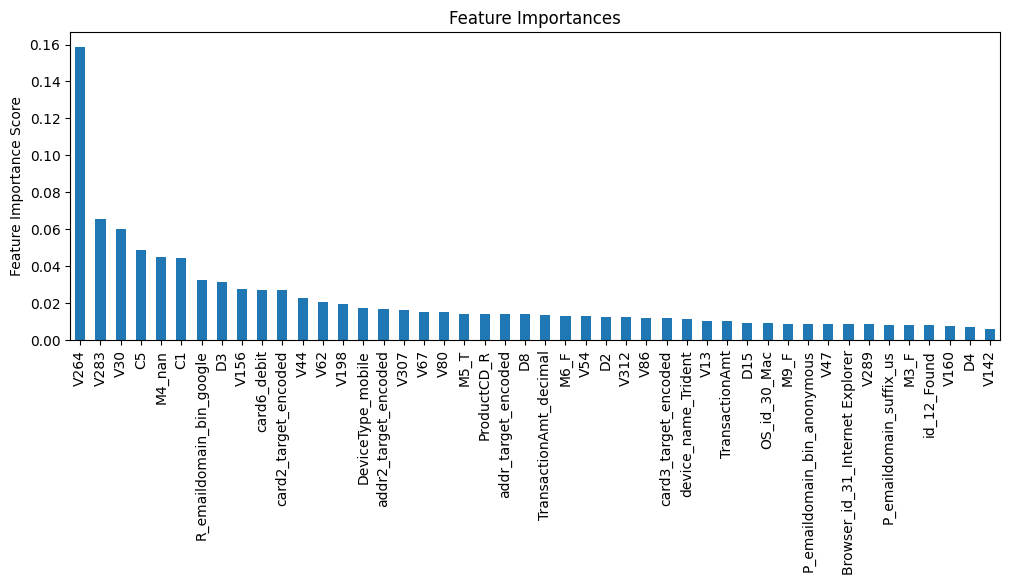

In [ ]:
xgb5 = XGBClassifier(
learning_rate=0.01,
    max_depth=5,
    min_child_weight=4,
    n_estimators=1000,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.9,
    objective='binary:logistic',
    reg_alpha=0.3,
    scale_pos_weight=scale_pos_weight,
    reg_lambda=0.243,
    tree_method='gpu_hist',
    seed=27
    )

modelfit(xgb5, merged_train, merged_test, predictors)

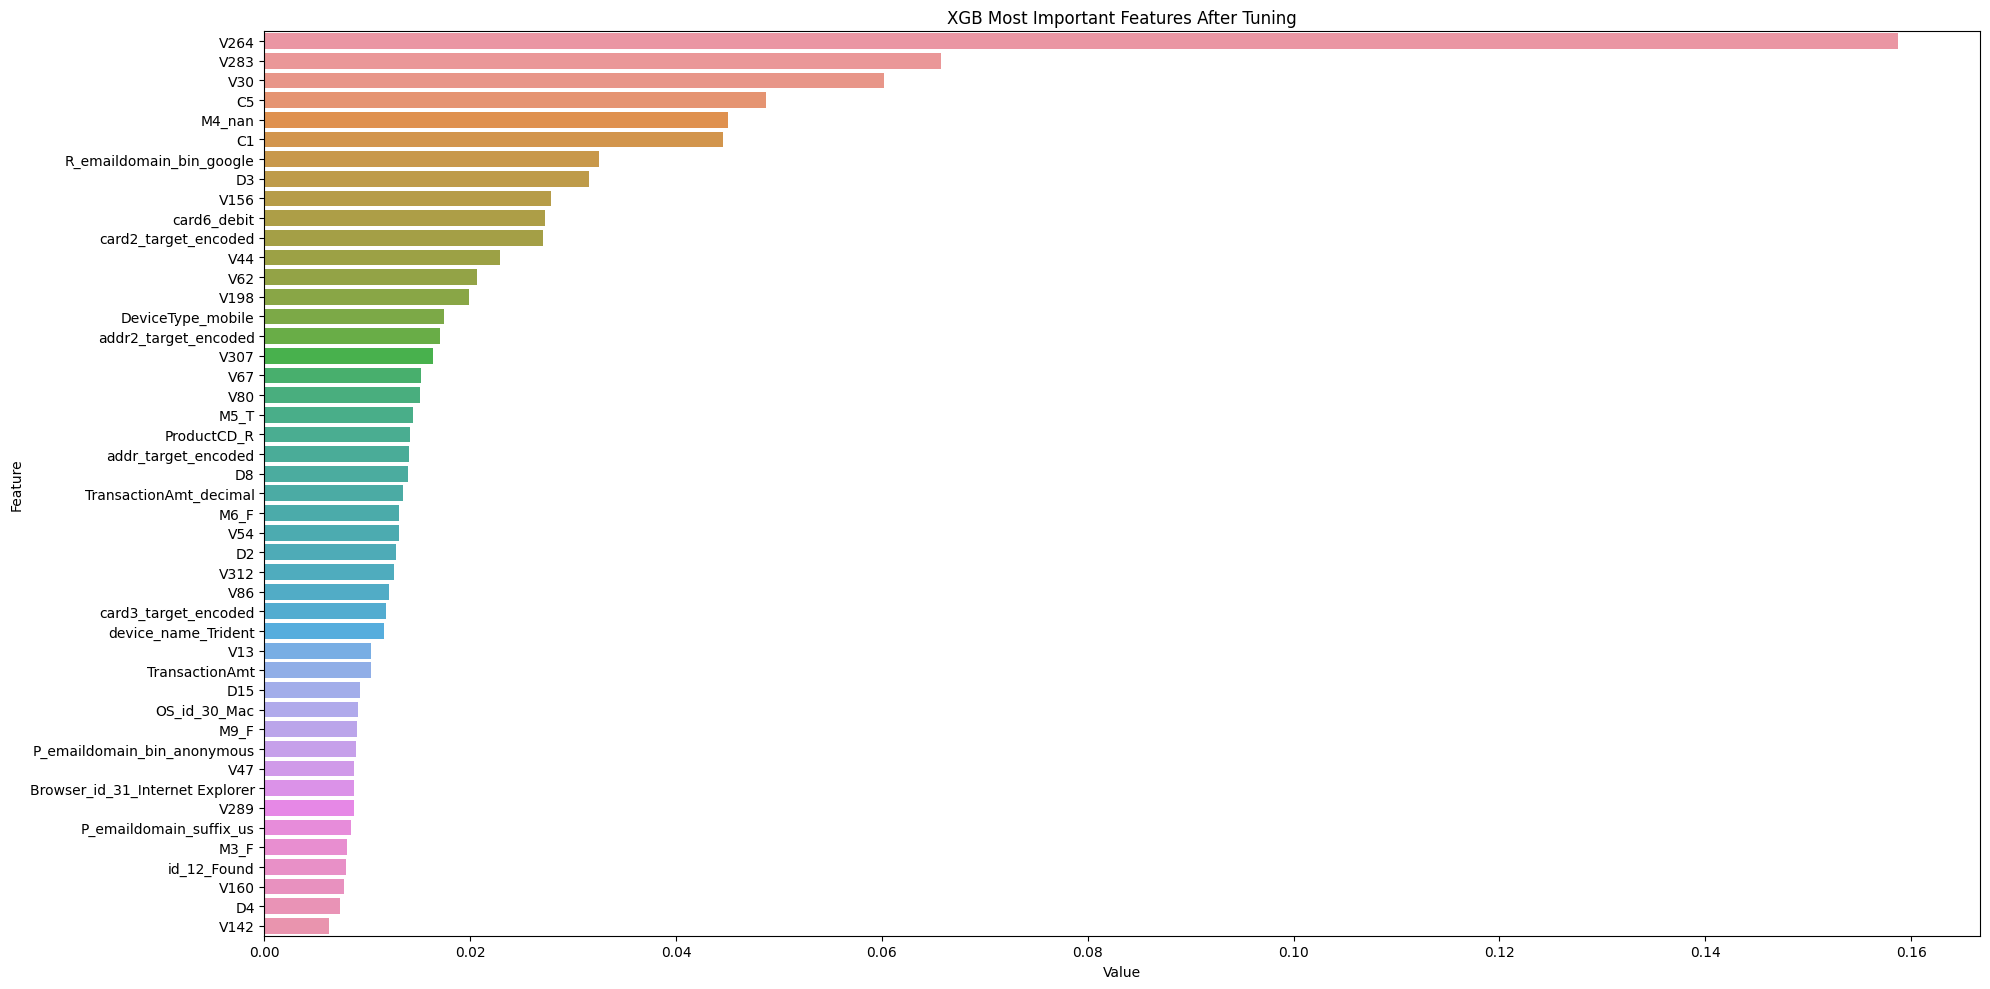

In [ ]:
# Feature Importance
cols = list( X_train_5.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb5.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()
# Plotting feature importance with selected 46 params
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features After Tuning')
plt.tight_layout()
plt.show()

In [ ]:
# 240 , 243 , 2598
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb5)
shap_values = explainer.shap_values(X_train_5)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[203,:], X_train_5.iloc[203,:])

In [ ]:
mybooster = xgb5.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

In [ ]:
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X_train_5)

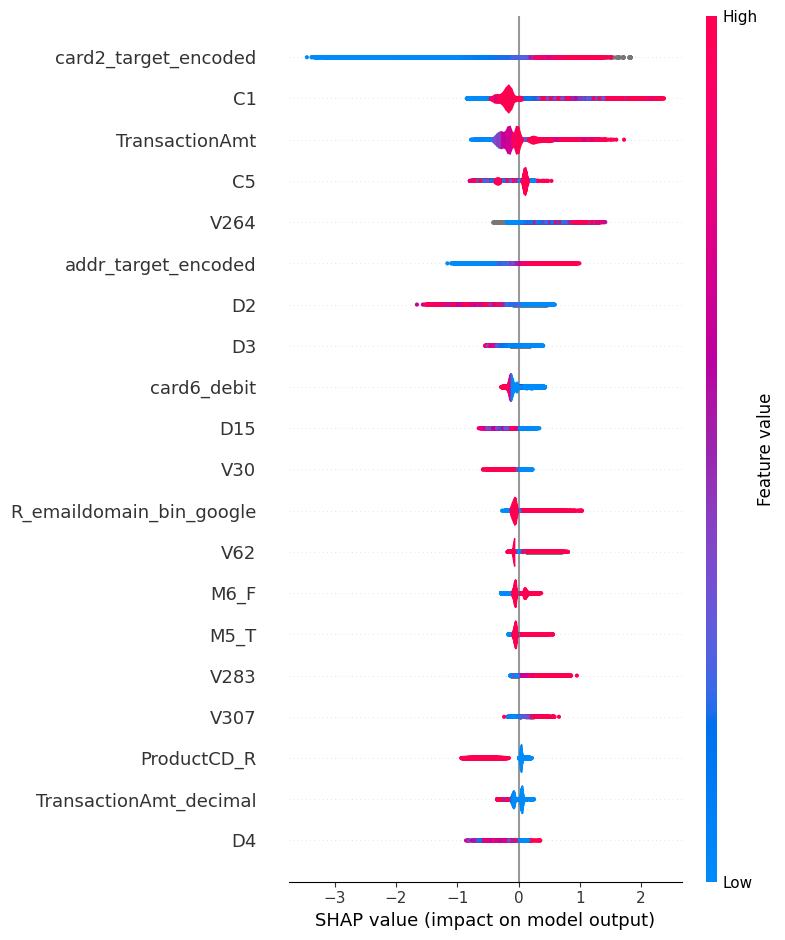

In [ ]:
shap.summary_plot(shap_values, X_train_5, plot_type='violin')